In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import assignment3_functions as library
import pandas as pd
import numpy as np
from sklearn import (svm, ensemble, tree,
                     linear_model, neighbors, naive_bayes, dummy)
pd.options.display.max_columns = 999
import warnings 
warnings.simplefilter('ignore')
from datetime import date, datetime, timedelta

## Explore Data

#### First, I load the data from Donors Choose

In [3]:
donors_df = library.file_to_dataframe("projects_2012_2013.csv")

#### Next, I create the target variable. I previously had done it backwards (labeling projects that did get funded within 60 days 1, and those that did not get funded 0, so here I have fixed that, because the prediction task is to determine the likelihood that a project will not be funded within 60 days

In [4]:
donors_df['date_posted'] = pd.to_datetime(donors_df['date_posted'], format='%m/%d/%y')
donors_df['datefullyfunded'] = pd.to_datetime(donors_df['datefullyfunded'], format='%m/%d/%y')
donors_df['60_days_fullyfunded'] = np.where(donors_df['datefullyfunded'] - donors_df['date_posted'] <= pd.to_timedelta(60, unit='days'), 0, 1)
donors_df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,60_days_fullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,f,f,Mrs.,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,2013-04-14,2013-05-02,0
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,f,f,Mrs.,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,2012-04-07,2012-04-18,0
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,f,f,Ms.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,2012-01-30,2012-04-15,1
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),f,t,Ms.,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,2012-10-11,2012-12-05,0
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,f,f,Mrs.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,2013-01-08,2013-03-25,1


#### Next, I look at my data to see which columns have NAs, and decide how to impute these values. In this case, I choose to just impute the continuous variable of students reached, during the pre-processing step.

In [5]:
library.na_summary(donors_df)

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

## Pre-Processing

#### Instead of hardcoding/dropping variables in place, I created a pre_processing function that takes lists of columns as its input, and then performs the necessary operations (imputing, dropping, etc). The parameters for that function are listed below. In constrast to my previous pipeline, the pre-processing step now occurs after the train, test split.

In [6]:
to_dummy_list = ['school_magnet', 'school_charter', 'eligible_double_your_impact_match']
categorical_list = ['teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'school_district', 'secondary_focus_subject', 'secondary_focus_area', 'school_state', 'school_city', 'school_metro', 'school_county']
continuous_impute_list = ['students_reached']
vars_to_drop_all = ['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_longitude', 'school_latitude']
vars_to_drop_dates = ['date_posted', 'datefullyfunded', '60_days_fullyfunded']

## Temporal Validation Analysis

#### Below, I fixed the function that determines the dates for the 3 train, test sets. I introduced a grace period that can be specified (60 days in this case), so that 60 days can be used to evaluate the impact of the intervention.

In [7]:
start_time_6mo = '2012-01-01'
end_time_6mo = '2013-12-31'
prediction_windows = [6]
temp_split_6mo = library.temporal_dates(start_time_6mo, end_time_6mo, prediction_windows, 60)
temp_split_6mo

[[datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 4, 30, 0, 0),
  datetime.datetime(2012, 7, 1, 0, 0),
  datetime.datetime(2012, 10, 31, 0, 0),
  6],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 10, 31, 0, 0),
  datetime.datetime(2013, 1, 1, 0, 0),
  datetime.datetime(2013, 4, 30, 0, 0),
  6],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2013, 4, 30, 0, 0),
  datetime.datetime(2013, 7, 1, 0, 0),
  datetime.datetime(2013, 10, 31, 0, 0),
  6]]

#### Below, I use the same parameter grid as before. I added in the Gradient Boost and Bagging Models, based on comments on my previous pipeline. I also found a way to make the training process go faster (introducing the n_jobs parameter), so I was able to run the analysis on the entire span of data.

In [8]:
models_to_run = ['RF', 'AB', 'LR', 'KNN', 'SVM', 'DT', 'GB', 'BG']
 
classifiers = {'RF': ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'LR': linear_model.LogisticRegression(penalty='l1', C=1e5, n_jobs=-1),
    'SVM': svm.LinearSVC(tol= 1e-5, random_state=0),
    'AB': ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'DT': tree.DecisionTreeClassifier(),
    'KNN': neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    'GB': ensemble.GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'BG': ensemble.BaggingClassifier(linear_model.LogisticRegression(penalty='l1', C=1e5, n_jobs=-1))
        }

parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5, 20, 100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.001,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,10,20,100],'min_samples_split': [2,5,10]},
    'SVM': {'C': [0.01]},
    'KNN': {'n_neighbors': [25],'weights': ['uniform','distance'],'algorithm': ['ball_tree']},
    'GB': {'n_estimators': [10], 'learning_rate': [0.1,0.5], 'subsample': [0.1,0.5], 'max_depth': [5]},
    'BG': {'n_estimators': [10], 'max_samples': [.5]}}

#### I create a list of thresholds to loop over instead of hardcoding

In [9]:
k_list = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 50.0]

In [10]:
results_df, params = library.run_models(models_to_run, classifiers, parameters, donors_df, '60_days_fullyfunded', temp_split_6mo, 'date_posted', categorical_list, to_dummy_list, continuous_impute_list, vars_to_drop_all, vars_to_drop_dates, k_list, 'table_test_30.csv')

Running through model RF...
Running through model AB...
Running through model LR...
Running through model KNN...
Running through model SVM...
Running through model DT...
Running through model GB...
Running through model BG...
Running through model RF...
Running through model AB...
Running through model LR...
Running through model KNN...
Running through model SVM...
Running through model DT...
Running through model GB...
Running through model BG...
Running through model RF...
Running through model AB...
Running through model LR...
Running through model KNN...
Running through model SVM...
Running through model DT...
Running through model GB...
Running through model BG...


#### After running through all the models, I produce a grid below that compares each model across various evaluation metrics (auc-roc, precision, recall, etc.) I added in f1 score, because it had been pointed out that I was missing that in my previous pipeline.

In [11]:
results_df

,train_start,train_end,test_start,test_end,model_type,classifier,train_size,test_size,auc-roc,p_at_1,a_at_1,r_at_1,f1_at_1,p_at_2,a_at_2,r_at_2,f1_at_2,p_at_5,a_at_5,r_at_5,f1_at_5,p_at_10,a_at_10,r_at_10,f1_at_10,p_at_20,a_at_20,r_at_20,f1_at_20,p_at_30,a_at_30,r_at_30,f1_at_30,p_at_50,a_at_50,r_at_50,f1_at_50
0,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.497928,0.387931,0.748862,0.0155226,0.0298507,0.339785,0.744698,0.0272508,0.0504551,0.402921,0.741393,0.08089,0.134731,0.354229,0.721946,0.14229,0.203027,0.331473,0.683695,0.266299,0.295333,0.361906,0.668241,0.436185,0.395589,0.339572,0.590667,0.682132,0.453425
1,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.499727,0.392241,0.748948,0.0156951,0.0301824,0.380645,0.74633,0.0305278,0.0565224,0.364261,0.737529,0.0731287,0.121804,0.373551,0.725809,0.150052,0.214101,0.364534,0.696918,0.29286,0.32479,0.349027,0.660513,0.420662,0.381511,0.325234,0.576329,0.653329,0.434279
2,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.495292,0.344828,0.748004,0.0137979,0.026534,0.348387,0.745042,0.0279407,0.0517324,0.398625,0.740963,0.0800276,0.133295,0.372692,0.725638,0.149707,0.213609,0.395019,0.70911,0.317351,0.351951,0.379365,0.678716,0.457227,0.414672,0.326093,0.577187,0.655053,0.435426
3,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.509430,0.465517,0.750408,0.0186271,0.0358209,0.421505,0.747961,0.0338048,0.0625898,0.411512,0.742251,0.0826147,0.137604,0.383856,0.72787,0.154191,0.220007,0.36754,0.69812,0.295274,0.327467,0.346737,0.65914,0.417903,0.379008,0.319567,0.570662,0.641945,0.426713
4,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.508002,0.25431,0.746201,0.0101759,0.0195688,0.337634,0.744612,0.0270783,0.0501357,0.341924,0.735297,0.0686444,0.114335,0.349077,0.720915,0.140221,0.200074,0.336625,0.685756,0.270438,0.299923,0.439325,0.71469,0.529493,0.480213,0.288315,0.539409,0.579165,0.384981
5,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.499413,0.349138,0.74809,0.0139703,0.0268657,0.365591,0.745729,0.0293205,0.0542871,0.347938,0.735898,0.0698517,0.116346,0.343924,0.719885,0.138151,0.197121,0.337913,0.686271,0.271473,0.301071,0.331139,0.649781,0.399103,0.361958,0.309865,0.56096,0.622456,0.413758
6,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.495908,0.262931,0.746372,0.0105209,0.0202322,0.277419,0.742208,0.0222491,0.0411943,0.380584,0.73916,0.0764057,0.127262,0.298411,0.710784,0.119869,0.171035,0.361314,0.69563,0.290273,0.32192,0.324699,0.645917,0.391342,0.354919,0.364214,0.615309,0.731632,0.486328
7,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.500862,0.318966,0.747489,0.012763,0.0245439,0.309677,0.743496,0.0248362,0.0459844,0.300687,0.731175,0.0603656,0.100546,0.300129,0.711127,0.120559,0.172019,0.314513,0.676913,0.252673,0.280222,0.315684,0.640508,0.380476,0.345065,0.294582,0.545677,0.591756,0.393351
8,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.503076,0.37069,0.748519,0.0148327,0.028524,0.397849,0.747016,0.0319076,0.0590771,0.387457,0.739847,0.0777854,0.12956,0.36067,0.723233,0.144878,0.206718,0.339201,0.686786,0.272508,0.302219,0.326703,0.647119,0.393756,0.357109,0.310981,0.562076,0.624698,0.415248
9,2012-01-01,2012-04-30,2012-07-01,2012-10-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",21180,23294,0.502870,0.340517,0.747918,0.0136254,0.0262023,0.372043,0.745986,0.0298379,0.0552451,0.385739,0.739675,0.0774405,0.128986,0.392872,0.729673,0.157813,0.225175,0.366681,0.697776,0.294584,0.

## Model Evaluation

#### After producing this grid, I identify the model with the best AUC-ROC score

In [12]:
results_without_baseline = results_df[results_df['model_type'] != 'baseline']
best_model = results_without_baseline.loc[results_without_baseline['auc-roc'].idxmax()]
best_model

train_start                                  2012-01-01 00:00:00
train_end                                    2012-10-31 00:00:00
test_start                                   2013-01-01 00:00:00
test_end                                     2013-04-30 00:00:00
model_type                                                    LR
classifier     LogisticRegression(C=10, class_weight=None, du...
train_size                                                 49680
test_size                                                  15017
auc-roc                                                 0.512807
p_at_1                                                      0.52
a_at_1                                                  0.702004
r_at_1                                                 0.0174068
f1_at_1                                                 0.033686
p_at_2                                                  0.526667
a_at_2                                                   0.70267
r_at_2                   

#### Here are the parameters for the model with the best AUC/ROC curve

In [13]:
params[92]

{'C': 0.1, 'penalty': 'l1'}

#### Now, I train this model and produce the precision/recall curve

In [18]:
x_train_log, x_test_log, y_train_log, y_test_log = library.temporal_split(donors_df, "date_posted" , "60_days_fullyfunded", best_model['train_start'], best_model['train_end'], best_model['test_start'], best_model['test_end'], vars_to_drop_dates)

In [19]:
x_train_log, x_test_log, features_log = library.pre_process(x_train_log, x_test_log, categorical_list, to_dummy_list, continuous_impute_list, vars_to_drop_all)
x_train_log = x_train_log[features_log]
x_test_log = x_test_log[features_log]
best_logistic = best_model['classifier']
best_logistic

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
y_pred_probs_best = best_logistic.fit(x_train_log, y_train_log).predict_proba(x_test_log)[:,1]

<Figure size 432x288 with 0 Axes>

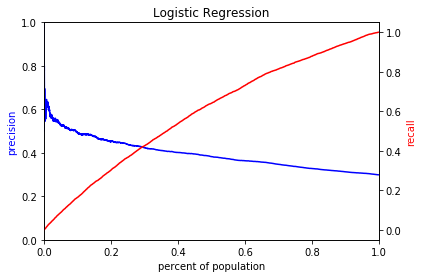

In [22]:
library.plot_precision_recall_n(y_test_log, y_pred_probs_best, "Logistic Regression")

#### Now I compare 5% precision, recall, and auc across models

In [23]:
model_compare = results_without_baseline[['model_type', 'auc-roc', 'p_at_5', 'r_at_5']]
model_compare[['p_at_5', 'r_at_5']] = model_compare[['p_at_5', 'r_at_5']].apply(pd.to_numeric)
model_compare = model_compare.groupby('model_type').mean()
model_compare.reset_index(inplace=True)

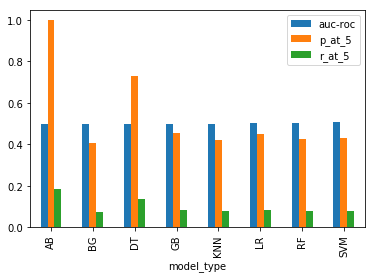

In [24]:
model_compare.plot(x='model_type', y=['auc-roc', 'p_at_5', 'r_at_5'], kind='bar')

#### Finally, I compare the models over time, across the various evaluation metrics

In [25]:
model_compare_time = results_without_baseline[['model_type', 'auc-roc', 'p_at_5', 'r_at_5', 'p_at_10', 'r_at_10', 'p_at_20', 'r_at_20', 'p_at_30', 'r_at_30', 'p_at_50', 'r_at_50', 'test_start']]
model_compare_time[['p_at_5', 'r_at_5', 'p_at_10', 'r_at_10', 'p_at_20', 'r_at_20', 'p_at_30', 'r_at_30', 'p_at_50', 'r_at_50']] = model_compare_time[['p_at_5', 'r_at_5', 'p_at_10', 'r_at_10', 'p_at_20', 'r_at_20', 'p_at_30', 'r_at_30', 'p_at_50', 'r_at_50']].apply(pd.to_numeric)
model_compare_time = model_compare_time.groupby(['model_type', 'test_start']).mean()
model_compare_time.reset_index(inplace=True)
model_compare_time

,model_type,test_start,auc-roc,p_at_5,r_at_5,p_at_10,r_at_10,p_at_20,r_at_20,p_at_30,r_at_30,p_at_50,r_at_50
0,AB,2012-07-01,0.501167,1.000000,0.200759,1.000000,0.401690,0.935809,0.751811,0.623784,0.751811,0.374259,0.751811
1,AB,2013-01-01,0.502712,1.000000,0.167373,1.000000,0.334970,1.000000,0.670163,0.783130,0.787324,0.469899,0.787324
2,AB,2013-07-01,0.497006,1.000000,0.187255,1.000000,0.374511,1.000000,0.749021,0.745353,0.837427,0.447183,0.837427
3,BG,2012-07-01,0.505130,0.373711,0.075026,0.338772,0.136081,0.321383,0.258192,0.317258,0.382373,0.287799,0.578130
4,BG,2013-01-01,0.498260,0.434667,0.072752,0.425050,0.142379,0.416250,0.278956,0.398224,0.400357,0.359483,0.602321
5,BG,2013-07-01,0.494898,0.405577,0.075946,0.396388,0.148451,0.376109,0.281714,0.356253,0.400261,0.330461,0.618844
6,DT,2012-07-01,0.498759,0.700745,0.140681,0.672821,0.270266,0.523052,0.420210,0.433887,0.522939,0.388129,0.779673
7,DT,2013-01-01,0.501341,0.747333,0.125084,0.722935,0.242161,0.595890,0.399344,0.526998,0.529820,0.458716,0.768588
8,DT,2013-07-01,0.498717,0.735425,0.137712,0.665624,0.249283,0.565471,0.423549,0.476671,0.535555,0.421084,0.788552
9,GB,2012-07-01,0.500191,0.399055,0.080114,0.389438,0.156433,0.365822,0.293894,0.348454,0.419972,0.323689,0.650224
